## TODO:
- Ampliar el soport de combinaciones válidas para las FKs.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append("../")

from src.detection.prediction_utils import choose_model, filter_predictions, visualize_boxes
from src.slides_utils.slides_utils import predict_tiles
from src.line_detection.hough import get_pairs
from src.ocr_utils.ocr import get_ocr_model, predict_ocr, generate_db

2023-02-22 22:07:01.042244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 22:07:03.137670: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-02-22 22:07:03.137815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nacho/TFI-Cazcarra/venv/lib/python3.8/site-packag

In [3]:
from PIL import Image
from torchvision import transforms as T

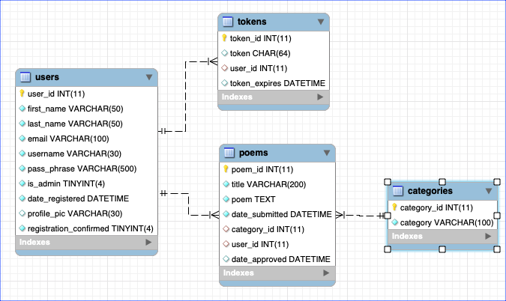

In [14]:
img_path = '/home/nacho/TFI-Cazcarra/data/imagenes_diagramas/ERDiagramsMySQL-5.png'
# img_path = '/home/nacho/TFI-Cazcarra/data/images_testing/test1.png'
img = Image.open(img_path).convert("RGB")

min_size = 600
max_size = 1333

transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
img.resize((int(s*0.75) for s in img.size))

## Predicciones sobre los objetos

In [15]:
model_tablas = choose_model(model_name="retinanet", object_to_predict="tablas")

Por ahora los modelos están en path diferentes. TODO: Habría que unificar.


In [16]:
model_cardinalidades = choose_model(model_name="retinanet", object_to_predict="cardinalidades")

Por ahora los modelos están en path diferentes. TODO: Habría que unificar.


In [17]:
tablas_pred = model_tablas([img_tensor])[1][0]
tablas_boxes, tablas_scores = filter_predictions(tablas_pred, nms_threshold=0.5)

In [18]:
cardinalidades_pred = predict_tiles(img, model=model_cardinalidades, is_yolo=False, transform=transform)
cardinalidades_boxes, cardinalidades_scores = filter_predictions(cardinalidades_pred, nms_threshold=0.5, 
                                                                 score_threshold=0.5)

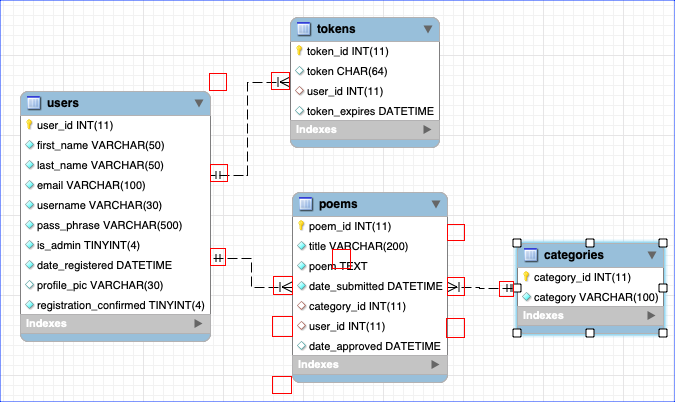

In [19]:
visualize_boxes(img, cardinalidades_boxes)

## Predicciones sobre las líneas

In [38]:
conexiones = get_pairs(tablas_boxes, cardinalidades_boxes, img=img, plot=False)

## OCR

In [34]:
ocr = get_ocr_model(det_algo="db", rec_algo="svtr", lang="en")

In [35]:
tablas_boxes_int = tablas_boxes.detach().numpy().astype(int)
all_tables, tables_names = predict_ocr(img=img, tablas=tablas_boxes_int, ocr_model=ocr, scale_percent=100)

In [1]:
code = generate_db(conexiones, all_tables, tables_names, lang="en")
print(code)

NameError: name 'generate_db' is not defined